In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  
  minlen = min(minlenarr)
  min_disea = type_disea[minlenarr.index(minlen)]
  
#   a = [df.loc[df['labels']==type_disea[0]]]
#   print(df.loc[df['labels']==type_disea[0]] )
#   a = pd.Series(df['labels'])
#   for i in type_disea:
#     a = df.loc[df['labels']==i]
  print('minlenarr ',minlenarr)
  print('type disea ',type_disea) 
  print('min len ',minlen)
  b = pd.DataFrame({})
  for i in type_disea:
    a = df.loc[df['labels'] == i]
    a = a.iloc[:minlen]
    b = pd.concat([b, a], ignore_index=True)
#   print(b)
  return b


minlenarr  [114, 64, 108, 132]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  64
Found 256 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726578638.771296     106 service.cc:145] XLA service 0x7bb360003aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726578638.771392     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726578741.311791     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.4363 - loss: 1.4054 - val_accuracy: 0.3810 - val_loss: 2.6437
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9156 - loss: 0.2570 - val_accuracy: 0.5619 - val_loss: 1.7953
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9728 - loss: 0.1092 - val_accuracy: 0.6762 - val_loss: 1.0517
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9692 - loss: 0.0604 - val_accuracy: 0.7238 - val_loss: 0.8947
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9855 - loss: 0.0759 - val_accuracy: 0.8381 - val_loss: 0.4550
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9951 - loss: 0.0210 - val_accuracy: 0.8952 - val_loss: 0.2980
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.8952 - val_loss: 0.2493
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9947 - loss: 0.0084 - val_accuracy: 0.8952 - val_loss: 0.2490
Epoch 9/15
8/8 ━━━

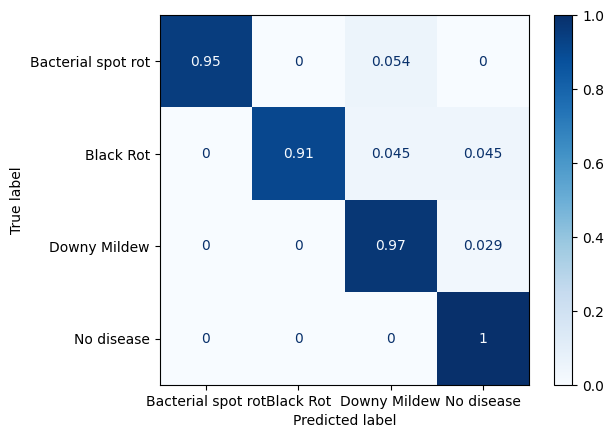

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.95      0.97        37
         Black Rot       1.00      0.91      0.95        22
      Downy Mildew       0.92      0.97      0.94        34
        No disease       0.95      1.00      0.98        40

          accuracy                           0.96       133
         macro avg       0.97      0.96      0.96       133
      weighted avg       0.96      0.96      0.96       133

minlenarr  [114, 63, 112, 129]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  63
Found 252 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 280s 19s/step - accuracy: 0.4796 - loss: 1.3841 - val_accuracy: 0.6286 - val_loss: 1.4235
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9056 - loss: 0.3375 - val_accuracy: 0.6667 - val_loss: 1.1277
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9431 - loss: 0.1827 - val_accuracy: 0.7333 - val_loss: 0.7245
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9767 - loss: 0.0735 - val_accuracy: 0.8571 - val_loss: 0.4620
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9873 - loss: 0.0654 - val_accuracy: 0.8857 - val_loss: 0.3359
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9901 - loss: 0.0227 - val_accuracy: 0.9143 - val_loss: 0.2802
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9980 - loss: 0.0231 - val_accuracy: 0.9333 - val_loss: 0.2227
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9973 - loss: 0.0102 - val_accuracy: 0.9333 - val_loss: 0.1600
Epoch 9/15
8/8 ━━

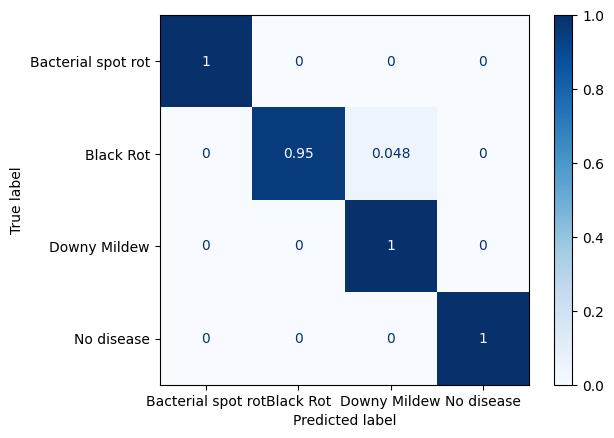

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

minlenarr  [108, 63, 111, 136]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  63
Found 252 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 265s 17s/step - accuracy: 0.3746 - loss: 1.6180 - val_accuracy: 0.3619 - val_loss: 2.9386
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8482 - loss: 0.4377 - val_accuracy: 0.3810 - val_loss: 3.0920
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9493 - loss: 0.1876 - val_accuracy: 0.4762 - val_loss: 2.0174
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9675 - loss: 0.1057 - val_accuracy: 0.6476 - val_loss: 1.1005
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9977 - loss: 0.0344 - val_accuracy: 0.7333 - val_loss: 0.7384
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9920 - loss: 0.0376 - val_accuracy: 0.7524 - val_loss: 0.6715
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9947 - loss: 0.0223 - val_accuracy: 0.7810 - val_loss: 0.5641
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.8381 - val_loss: 0.4582
Epoch 9/15
8/8 ━━

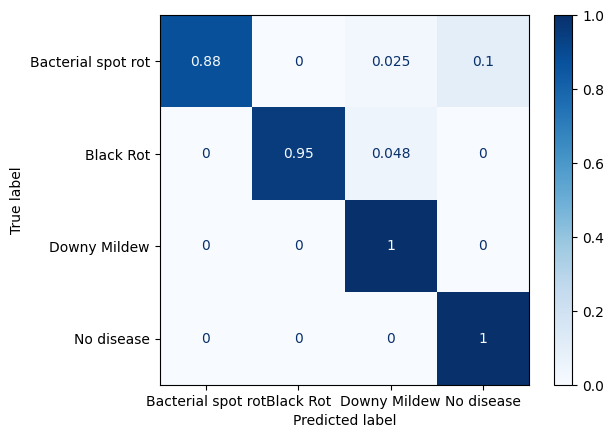

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.88      0.93        40
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.94      1.00      0.97        34
        No disease       0.90      1.00      0.95        38

          accuracy                           0.95       133
         macro avg       0.96      0.96      0.96       133
      weighted avg       0.96      0.95      0.95       133

minlenarr  [116, 66, 109, 128]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  66
Found 264 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/9 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.4352 - loss: 1.4396

I0000 00:00:1726580747.580357     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 269s 15s/step - accuracy: 0.4573 - loss: 1.3859 - val_accuracy: 0.3942 - val_loss: 1.5930
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8678 - loss: 0.3393 - val_accuracy: 0.6442 - val_loss: 0.9062
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9506 - loss: 0.1992 - val_accuracy: 0.7212 - val_loss: 0.6833
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9877 - loss: 0.0452 - val_accuracy: 0.7404 - val_loss: 0.8015
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9992 - loss: 0.0273 - val_accuracy: 0.7981 - val_loss: 0.5948
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9989 - loss: 0.0281 - val_accuracy: 0.7981 - val_loss: 0.6727
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9866 - loss: 0.0683 - val_accuracy: 0.8462 - val_loss: 0.4303
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9957 - loss: 0.0175 - val_accuracy: 0.9038 - val_loss: 0.3901
Epoch 9/15
9/9 ━━

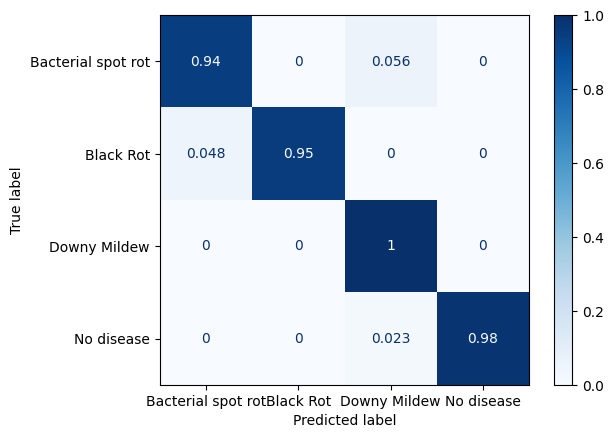

                    precision    recall  f1-score   support

Bacterial spot rot       0.97      0.94      0.96        36
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.92      1.00      0.96        33
        No disease       1.00      0.98      0.99        43

          accuracy                           0.97       133
         macro avg       0.97      0.97      0.97       133
      weighted avg       0.97      0.97      0.97       133

minlenarr  [112, 64, 112, 131]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  64
Found 256 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - accuracy: 0.4480 - loss: 1.4084 - val_accuracy: 0.3365 - val_loss: 3.1885
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8704 - loss: 0.3555 - val_accuracy: 0.3462 - val_loss: 2.6111
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9617 - loss: 0.1152 - val_accuracy: 0.4327 - val_loss: 1.8579
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9841 - loss: 0.0582 - val_accuracy: 0.4808 - val_loss: 1.4577
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9803 - loss: 0.0388 - val_accuracy: 0.6058 - val_loss: 0.9235
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9901 - loss: 0.0544 - val_accuracy: 0.8942 - val_loss: 0.3961
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9868 - loss: 0.0272 - val_accuracy: 0.9327 - val_loss: 0.2359
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9901 - loss: 0.0123 - val_accuracy: 0.9519 - val_loss: 0.1714
Epoch 9/15
8/8 ━━━

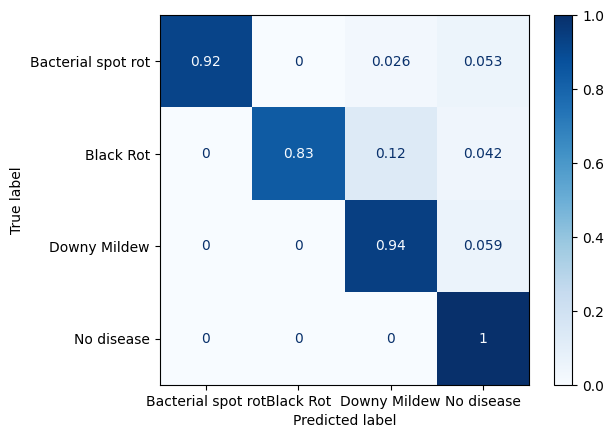

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.92      0.96        38
         Black Rot       1.00      0.83      0.91        24
      Downy Mildew       0.89      0.94      0.91        34
        No disease       0.88      1.00      0.94        37

          accuracy                           0.93       133
         macro avg       0.94      0.92      0.93       133
      weighted avg       0.94      0.93      0.93       133



In [8]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])
epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  a = make_balance_train(train_df.loc[train_idx])
  b = train_df.loc[valid_idx]
  train = ImageDataGenerator().flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)